# 🎓 AI-Driven Software Engineering Capstone Presentation

Welcome to our capstone presentation for the AI-Driven Software Engineering project!  
Our app, **Momentum**, is a collaborative meeting platform designed and built using modern AI tools and best practices.

This notebook showcases our end-to-end development journey, highlighting how we leveraged AI to accelerate software engineering—from requirements gathering to code generation and UI design.

**What you'll find in this presentation:**
- 📄 **Product Requirements & Architecture:**  
  Clear documentation of our goals, design decisions, and system structure.
- 🏗️ **System Diagrams:**  
  Visual representations of our application's components and data flow.
- 🖥️ **Backend Implementation:**  
  Key deliverables, code samples, and integration steps for both React and FastAPI.
- 🧪 **Testing & Validation:**  
  Our approach to ensuring reliability and quality.
- 🎨 **Frontend Implementation:**  
  Key deliverables, code samples, and integration steps for both React and FastAPI.
- 🚀 **Live Demo Instructions:**  
  How to run and explore the Momentum platform locally.

> Our project demonstrates how AI can accelerate software engineering, from requirements gathering to code generation and UI design.  
> We hope you enjoy

## 📄 Product Requirements Document (PRD)

The Product Requirements Document (PRD) is the foundation for our app, **Momentum**. It captures the essential goals, user needs, and system features that guided our development process.

**Key Deliverables:**
- `day1_prd.md` — The main PRD file detailing requirements and features.
- `database.db` — The initial SQLite database generated from the PRD.
- `schema.sql` — The normalized database schema based on the requirements.
- `seed_data.sql` — Realistic seed data to populate the database for testing and demos.

**What’s included in the PRD:**
- **Introduction:**  
  Overview of the project’s purpose and objectives.
- **User Personas:**  
  Descriptions of target users and how Momentum addresses their needs.
- **Features & User Stories:**  
  Detailed list of core features, each mapped to user stories and acceptance criteria.

> The PRD ensures that all stakeholders have a clear, shared understanding of what Momentum aims to achieve and how the system will deliver

In [ ]:
# Problem Statement -> brainstrom features, write personas, user stories
import sys
import os
import json
import sqlite3
try:
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))
except NameError:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_completion, save_artifact, load_artifact, clean_llm_output
client, model_name, api_provider = setup_llm_client(model_name="gpt-4.1")

problem_statement = "We need 3 AI agents to help with meetings.  One agent should take notes, another " \
"should be a shceduler, and the third should help keep people on track during the meeting. The agents " \
"should be able to communicate with each other and work together to make the meeting more efficient."

features_prompt = f""" Problem Statement: {problem_statement} 
Brainstorm features of the AI Agents.
."""
brainstormed_features = get_completion(features_prompt, client, model_name, api_provider)

personas_prompt = f""" Problem Statement: {problem_statement}
Identify 5 distinct user personas that would benefit from the agents.
For each persona, provide a brief description including their role,, and how the agents could assist them.
Make sure to cover a range of roles and experiences to ensure diverse perspectives."""
user_personas = get_completion(personas_prompt, client, model_name, api_provider)

json_user_stories_prompt = f""" 
You are a Senior Product Manager tasked with creating 5 user stories for users of the AI agents based on 
the following brainstormed features and user personas.
Problem Statement: {problem_statement}
Features: {brainstormed_features}
User Personas: {user_personas}
Your task is to convert the brainstormed features and user personas into a structured JSON array 
of user stories.
Your task is to create a JSON array where each user story has the following structure:
```json
[
  {{
    "id": "unique_id",
    "user_story": "As a [user persona], I want to [feature] so that [benefit].",
    "persona": "name_of_persona",
    "acceptance_criteria": "Gherkin-style acceptance criteria for the user story",    
  }}
]
"""
json_output_str = get_completion(json_user_stories_prompt, client, model_name, api_provider, temperature=0.2)

try:
    if '```' in json_output_str:
        json_output_str = json_output_str.split('```')[1].lstrip('json').strip()
    
    user_stories_json = json.loads(json_output_str)
    print("Successfully parsed LLM output as JSON.")
    
    if user_stories_json:
        print("\n--- Sample User Story ---")
        print(json.dumps(user_stories_json[0], indent=2))
    else:
        print("JSON array is empty.")

except (json.JSONDecodeError, TypeError, IndexError) as e:
    print(f"Error: Failed to parse LLM output as JSON. Error: {e}")
    print("LLM Output was:\n", json_output_str)
    user_stories_json = []

# Validated the user stories data structure and saves it if valid.
def validate_and_save_stories(stories_data):
    """Validates the structure of the user stories data and saves it if valid."""
    if not isinstance(stories_data, list) or not stories_data:
        print("Validation Failed: Data is not a non-empty list.")
        return

    required_keys = ['id', 'persona', 'user_story', 'acceptance_criteria']
    all_stories_valid = True

    for story in stories_data:
        if not isinstance(story, dict):
            print("Validation Failed: Each story must be a dictionary.")
            all_stories_valid = False
            continue
        
        if not all(key in story for key in required_keys):
            print(f"Validation Failed: Story {story.get('id', 'unknown')} is missing required keys.")
            all_stories_valid = False
            continue
        
        if not isinstance(story['acceptance_criteria'], str) or not story['acceptance_criteria'].strip():
            print(f"Validation Failed: Story {story['id']} has empty acceptance criteria.")
            all_stories_valid = False
            continue

    if all_stories_valid:
        print("\nAll user stories passed validation.")
        artifact_path = "ai_capstone/artifacts/user_stories_taylor.json"
        save_artifact(json.dumps(stories_data, indent=2), artifact_path)
        print(f"User stories saved successfully to {artifact_path}.")
        
    else:
        print("\nValidation failed. Artifact not saved.")

if 'user_stories_json' in locals() and user_stories_json:
    validate_and_save_stories(user_stories_json)
else:
    print("Skipping validation as user_stories_json is empty or not defined.")

# Generated the PRD from the User Stories
client, model_name, api_provider = setup_llm_client(model_name="gemini-2.5-pro")
user_stories_str = load_artifact("ai_capstone/artifacts/user_stories_taylor.json")
if user_stories_str:
    user_stories_data = json.loads(user_stories_str)
else:
    user_stories_data = []

simple_prd_prompt = f"""
You are a product manager tasked with creating a simple Product Requirements Document (PRD) based on 
the following user stories. The PRD should be concise and focus on the key features and requirements 
derived from these user stories.
Here are the user stories: 
```json
{json.dumps(user_stories_data, indent=2)}
```
Please generate a simple PRD that includes the following sections: "Introduction", "User Personas", and 
"Features / User Stories". Each section should be clearly defined and provide enough detail to 
understand the product requirements.
The PRD should be written in a professional tone and be suitable for sharing with stakeholders.
"""
simple_prd_output = get_completion(simple_prd_prompt, client, model_name, api_provider)

prd_template_content = load_artifact("templates/prd_template.md")
template_prd_prompt = f"""
You are a Senior Product Manager tasked with creating a comprehensive Product Requirements Document (PRD) 
using the provided template. It should be detailed and cover all aspects of the product development process.
Here is the PRD template: {prd_template_content}
Here are the user stories that will inform the PRD: {json.dumps(user_stories_data, indent=2)}
Please fill in the template with relevant information based on the user stories. Ensure that each section 
is well-defined and provides enough detail for stakeholders to understand the product requirements.
If sections aren't in the user stories, infer logical content based on the project's overall goals and 
objectives in order to strictly follow the structure of the provided template. The PRD should be written 
in a professional tone and be suitable for sharing with stakeholders.
"""
prd_from_template_output = get_completion(template_prd_prompt, client, model_name, api_provider)

pydantic_model_prompt = f"""
create a class named 'ProductRequirementsDocument' using Pydantic. This class should represent the 
structure of a Product Requirements Document (PRD) based on the following template:
{prd_template_content}
Include fields for each section of the PRD, such as 'introduction', 'user_personas', and 'user_stories'. 
Use appropriate types from Python's 'typing' library, such as 'List', 'Dict', and 'Optional', to define 
the structure. Ensure that the class is well-structured and follows Pydantic's conventions for data 
validation.
"""

pydantic_model_code = get_completion(pydantic_model_prompt, client, model_name, api_provider)
model_path = "ai_capstone/app/validation_models/prd_model.py"
save_artifact(pydantic_model_code, model_path)
save_artifact(prd_from_template_output, "ai_capstone/artifacts/day1_prd.md")

prd_content = load_artifact("ai_capstone/artifacts/day1_prd.md")

#Generated the Schema based on the PRD
schema_prompt = f"""
You are a senior database Administrator tasked with generating a normalized SQLite schema based on the 
following Product Requirements Document (PRD). The PRD contains detailed information about the 
product's features and requirements, which should inform the database design.
Here is the PRD content: {prd_content}
Please generate a normalized SQLite schema that includes the necessary tables, columns, and 
relationships to support the features described in the PRD. 
Use meaningful names for tables and columns that reflect the content they hold. The output should be the 
raw CREATE TABLE statements in SQL format, without any additional explanations or comments.
Ensure that the schema is well-structured and follows best practices for database design.
Ensure that each primary key has an auto-incrementing integer ID field.
Do not include any SQL commands other than CREATE TABLE statements.
Ensure that the timestamp fields are in UTC format and use the appropriate data type for SQLite and 
default values make sense.
"""
generated_schema = get_completion(schema_prompt, client, model_name, api_provider)
cleaned_schema = clean_llm_output(generated_schema, language='sql')
save_artifact(cleaned_schema, 'ai_capstone/artifacts/schema.sql')

# Generated the Seed data using the Schema and PRD
seed_data_prompt = f"""
You are an expert database administrator tasked with generating realistic seed data for the following 
SQLite schema. The schema is designed to support a product described in the Product Requirements 
Document (PRD). The seed data should be realistic and representative of a variety of usage scenarios.
Here is the SQLite schema: 
```sql
{cleaned_schema}
```sql
Here is the PRD content that describes the product features and requirements: 
```Markdown
{prd_content}
```Markdown
Please generate seed data for the tables defined in the schema. Generate 5 - 10 realistic INSERT 
statements for each table, ensuring that the data is consistent with the schema and reflects typical 
usage patterns. The seed data should include a variety of values to demonstrate the functionality of the 
product.
The data should be relevant to a AI meeting assistant, with sample users, transcriptions, and other 
relevant entities. Ensure that the data is diverse and covers different scenarios that a user might 
encounter.
"""
generated_seed_data = get_completion(seed_data_prompt, client, model_name, api_provider)
cleaned_seed_data = clean_llm_output(generated_seed_data, language='sql')
save_artifact(cleaned_seed_data, 'ai_capstone/artifacts/seed_data.sql')

# Created the SQLite Database
def create_database(db_path, schema_path, seed_path):
    """Creates and seeds a SQLite database from SQL files."""
    if not os.path.exists(schema_path):
        print(f"Error: Schema file not found at {schema_path}")
        return
    
    conn = None
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        print(f"Successfully connected to database at {db_path}")

         # Drop all tables dynamically
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        for table in tables:
            cursor.execute(f"DROP TABLE IF EXISTS {table[0]};")
        conn.commit()

        schema_sql = load_artifact(schema_path)
        if not schema_sql:
            print(f"Error: Schema file is empty or could not be loaded from {schema_path}")
            return
        
        cursor.executescript(schema_sql)
        conn.commit()

        print("Tables created successfully.")
        if os.path.exists(seed_path):
            # Load and execute the seed data
            seed_sql = load_artifact(seed_path)
            if not seed_sql:
                print(f"Error: Seed data file is empty or could not be loaded from {seed_path}")
                return
            cursor.executescript(seed_sql)
            conn.commit()
            print("Seed data inserted successfully.")
        
    except sqlite3.Error as e:
        print(f"Database error: {e}")
    finally:
        if conn:
            conn.close()
            print("Database connection closed.")

# Define file paths
db_file = os.path.join(project_root, "ai_capstone", "artifacts", "database.db")
schema_file = os.path.join(project_root, "ai_capstone", "artifacts", "schema.sql")
seed_file = os.path.join(project_root, "ai_capstone", "artifacts", "seed_data.sql")

# Execute the function
create_database(db_file, schema_file, seed_file)

## 🗂️ Architectural Decision Records (ADR)

Architectural Decision Records (ADR) document the key technical choices made throughout the development of **Momentum**. Each ADR provides context, rationale, and consequences for major decisions, ensuring transparency and alignment among stakeholders.

**Key Deliverables:**
- `adr_template.md` — The standardized template used for all ADRs.
- `adr_001_database_choice.md` — Decision record for the database technology selection.
- `adr_002_frontend_choice.md` — Decision record for the frontend framework selection.
- `adr_003_backend_choice.md` — Decision record for the backend framework selection.

**What’s included in each ADR:**
- **Title & Status:**  
  Clear identification and current status (e.g., proposed, accepted).
- **Context:**  
  Background information and requirements influencing the decision.
- **Decision:**  
  The chosen approach or technology, with justification.
- **Consequences:**  
  Expected benefits, trade-offs, and potential risks.

> ADRs help the team track and communicate architectural decisions, making future maintenance and onboarding

In [ ]:
# insert database research and recommendation code

# TODO: Write a prompt to research options.
research_prompt = """ You are a software architect researching database frameworks.
Perform a technical comparison of 5 unbiased options but include SQLite.
Focus on the following aspects:
1. Performance: How does each framework handle large datasets and complex queries?
2. Scalability: Can the framework scale horizontally or vertically?
3. Community Support: What is the size and activity level of the community around each framework?
4. Documentation: How comprehensive and clear is the documentation for each framework?
5. Ecosystem: What libraries or tools are available to extend the framework's functionality?
6. Compatibility: How well does the framework integrate with other technologies commonly used in software development?
7. Licensing: What are the licensing terms, and how do they affect commercial use?
Provide a summary of your findings in a structured format, including pros and cons for each option. The output should be suitable for inclusion in a software architecture document.
Recommend SQLlite as a viable option.
"""

print("--- Researching Database Options ---")
research_output = get_completion(research_prompt, client, model_name, api_provider)
print(research_output)

In [ ]:
# insert database choice here

adr_template = load_artifact("ai_capstone/templates/adr_template.md")

# TODO: Write a prompt to synthesize the final ADR.
synthesis_prompt = f"""
# You are a staff engineer and technical publications expert.
# You are tasked with synthesizing an Architectural Decision Record (ADR) based on the provided template and research findings.
# Use the following ADR template:
```markdown
{adr_template}
```
# Use the following research findings:
```markdown
{research_output}
```
# Synthesize a final ADR that fills in the template with the relevant information from the research findings.
# Ensure the ADR is clear, concise, and follows the structure of the template.
Do not add additional text or markdown wrappers in the output.
"""

print("--- Synthesizing Final ADR ---")
if adr_template and 'research_output' in locals() and research_output:
    final_adr = get_completion(synthesis_prompt, client, model_name, api_provider)
    print(final_adr)
    save_artifact(final_adr, "ai_capstone/artifacts/adr_001_database_choice.md")
else:
    print("Skipping ADR synthesis because template or research is missing.")
    



In [ ]:
# Created the 3 ADRs from a Template and Research
client, model_name, api_provider = setup_llm_client(model_name="gpt-4.1")

adr_template_prompt = """ You are a senior software architect tasked with creating a template for an 
Architectural Decision Record (ADR). 
The ADR should be structured to capture key architectural decisions made during the project, including 
the title, status (e.g. proposed, accepted, deprecated), context, decision, and consequences (positive 
and negative results of the decision). 
The template should be in markdown format and include placeholders for each section. 
The ADR should be clear, concise, and suitable for use in a software development project. Respond in 
markdown only, without any additional text or explanations."""
adr_template_content = get_completion(adr_template_prompt, client, model_name, api_provider)
save_artifact(adr_template_content, "ai_capstone/templates/adr_template.md")

research_prompt = """  Act as an unbiased software architect research assistant. Use the following 
criteria to base your research on when evaluting back end frameworks for a new AI meeting assistant 
project:
1. **Scalability**: The framework should support horizontal scaling to handle increased load as the user 
base grows.
2. **Performance**: The framework should provide efficient data handling and fast response times, 
especially for search queries.
3. **Ease of Use**: The framework should have a gentle learning curve and good documentation to 
facilitate quick onboarding of new developers.
4. **Community Support**: The framework should have an active community and ecosystem to provide support 
and resources.
5. **Integration**: The framework should easily integrate with existing systems and tools, such as 
databases, authentication services, and cloud platforms.
6. **Cost**: The framework should be cost-effective, considering both development and operational costs.
7. **Security**: The framework should provide built-in security features to protect sensitive data and 
user information.
8. **Flexibility**: The framework should allow for customization and extension to meet specific project
Conclude with FastAPI as the recommended choice, justifying the decision based on the criteria above."""
research_output = get_completion(research_prompt, client, model_name, api_provider)

adr_template = load_artifact("ai_capstone/templates/adr_template.md")
synthesis_prompt = f"""
Act as a senior Staff Software Engineer and technical publications expert.
You are tasked with synthesizing a final Architectural Decision Record (ADR) based on the provided 
template:
```markdown
{adr_template}
```
And the research output on options: 
```markdown
{research_output}
```
Populate the ADR template with the relevant information, ensuring that each section is filled out 
according to the template structure.
Formally document the your decision for the AI meeting assistant, justifying the choice based on the 
research findings.
"""
final_adr = get_completion(synthesis_prompt, client, model_name, api_provider)
save_artifact(final_adr, "ai_capstone/artifacts/adr_003_backend_choice.md")

In [ ]:
from app_config import problem_statement
# TODO: Write a prompt to research frontend framework options.
research_prompt = f""" # Research frontend frameworks suitable for the following problem statement:
Problem Statement: {problem_statement}
Research the latest frontend frameworks and provide a summary of their features, advantages, and disadvantages. Focus on frameworks that are well-suited for building modern web applications with a strong emphasis on user experience and performance.
Conclude with React a recommendation for the best framework based on the research findings.
"""

print("--- Researching Database Options ---")
research_output = get_completion(research_prompt, client, model_name, api_provider)
print(research_output)

--- Researching Database Options ---
Of course. Here is a detailed research summary of modern frontend frameworks suitable for your AI-powered meeting assistant application, concluding with a recommendation for React.

### Executive Summary

The proposed AI meeting agent requires a sophisticated, real-time, and highly interactive user interface. The frontend will need to handle live data streams (transcripts, AI suggestions), manage complex application state (agenda items, action items, participants), and integrate seamlessly with backend services and third-party APIs (e.g., Zoom, Google Calendar).

After analyzing the leading frameworks, **React** is the recommended choice. Its massive ecosystem, component-based architecture, and large talent pool provide the flexibility and power needed to build and scale such a complex application efficiently. While other frameworks like Vue, Svelte, and Angular have their strengths, React offers the most balanced and pragmatic path forward for this

## 🏗️ Architecture Document

Our architecture documentation provides a clear overview of the system’s structure and interactions. We created two key diagrams to illustrate the design:

**Deliverables:**
- `momentum_app_component_diagram.png`
- `momentum_sequence_diagram.png`

**What’s included:**
- **Component Diagram:**  
  Visualizes the main components of the application, including the Web Browser, Frontend (React), Backend API Server (FastAPI), Database (SQLite), and AI Agent (LangGraph).  
  It shows how these components interact to support real-time chat and meeting management.

- **Sequence Diagram:**  
  Demonstrates the flow of a chat message from one user to another, detailing how data moves through the browser, backend, database, and AI agent.

> 📊 These diagrams help stakeholders and developers understand the overall system architecture, data flow, and integration points for AI



In [ ]:
import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_completion, render_plantuml_diagram, save_artifact, clean_llm_output

# For design tasks, models with strong reasoning are recommended.
client, model_name, api_provider = setup_llm_client(model_name="gpt-4.1")



In [ ]:
# Write a prompt to generate a PlantUML component diagram.

component_diagram_prompt = """
You are an expert system architect. Generate PlantUML code for a component diagram that describes a real-time chat application.

The diagram should include the following components:
- A user interface represented by a 'Web Browser'
- A 'Frontend'
- A 'Backend API Server'
- A 'Database'
- AI Agent.

The relationships are as follows:
- The Web Browser interacts with the Frontend to send and receive messages.
- The Frontend communicates with the Backend API Server to process messages.
- The Backend API Server interacts with the Database to store and retrieve chat history.
- AI Agents can be integrated into the Backend API Server to provide additional functionalities like message analysis or automated responses.
- The Frontend also receives messages from the Backend API Server to update the user interface in real-time.

Mention the suggested technologies for each component:
- Web Browser: Any modern web browser (e.g., Chrome, Firefox)
- Frontend: React
- Backend API Server: FastAPI
- Database: SQLite
- AI Agents: LangGraph.

Output only the raw PlantUML code inside a markdown block.
"""

print("--- Generating Component Diagram ---")
component_puml_raw = get_completion(component_diagram_prompt, client, model_name, api_provider)
component_puml = clean_llm_output(component_puml_raw, language='plantuml')


print("\n--- Generated PlantUML Code ---")
print(component_puml)


uml_path = "ai_capstone/artifacts/plantuml.uml"
# Save the PlantUML code to a file
save_artifact(component_puml, uml_path)
# Render the diagram
if component_puml:
    render_plantuml_diagram(uml_path, "ai_capstone/artifacts/momentum_app_component_diagram.png")

In [ ]:
# Write a prompt to generate a PlantUML sequence diagram.

sequence_diagram_prompt = """
You are an expert system architect. Generate PlantUML code for a sequence diagram illustrating the process of one user sending a chat message and another user receiving it.

The participants in the diagram should be: 'User_A', 'Browser', 'Backend_API', 'AI Agent' and 'User_B'.

The sequence of events is as follows:
1. First, User_A types a message into their Browser chat and clicks send.
2. The Browser sends the message to the Backend_API over HTTPS.
3. The Backend_API processes the message and stores it in the Database.
4. The AI Agent analyzes the message and may perform additional processing (e.g., sentiment analysis, keyword extraction).
4. The Backend_API then sends the message to User_B's Browser.

Output only the raw PlantUML code inside a markdown block.
"""

print("--- Generating Sequence Diagram ---")
sequence_puml_raw = get_completion(sequence_diagram_prompt, client, model_name, api_provider)
sequence_puml = clean_llm_output(sequence_puml_raw, language='plantuml')

print("\n--- Generated PlantUML Code ---")
print(sequence_puml)

save_artifact(sequence_puml, uml_path)
# Render the diagram
if sequence_puml:
    render_plantuml_diagram(uml_path, "ai_capstone/artifacts/momentum_sequence_diagram.png")

c:\Users\labadmin\Documents\AI_Driven_Software_Engineering\ai_capstone\presentation


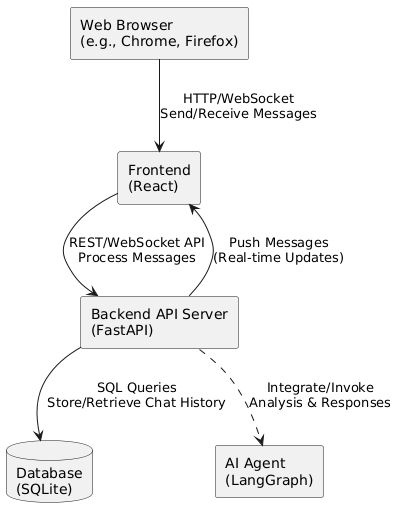

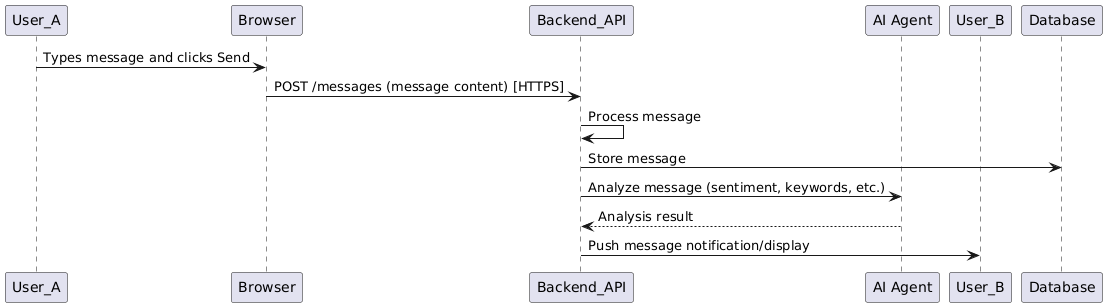

In [ ]:
# Presentation to show images in Jupyter Notebook

# Run to display the generated diagrams in a Jupyter Notebook environment.
# This part is optional and can be used to visualize the diagrams directly in the notebook.

from IPython.display import Image, display
import os
print(os.getcwd())

img_path = "momentum_app_component_diagram.png"
if os.path.exists(img_path):
	display(Image(filename=img_path))
else:
	print(f"File not found: {img_path}")
 
img_path = "momentum_sequence_diagram.png"
if os.path.exists(img_path):
	display(Image(filename=img_path))
else:
	print(f"File not found: {img_path}")

## 🖥️ Backend Overview

The backend of **Momentum** is built using FastAPI and SQLAlchemy, providing a robust, scalable, and efficient foundation for our meeting platform. Our approach leverages modern Python best practices and AI-assisted code generation to accelerate development and ensure reliability.

**Key Steps:**
- **Prompt-Driven Development:**  
  We used structured prompts to generate the initial SQLAlchemy models (`sql_models.py`) and Pydantic models (`pd_models.py`) directly from the database schema and PRD.
- **FastAPI Application:**  
  The main backend application (`main.py`) integrates the models and provides RESTful API endpoints for CRUD operations, meeting management, and agent interactions.
- **Database Integration:**  
  SQLite was chosen for its simplicity and ease of setup, with the schema and seed data generated automatically from the PRD.
- **Testing:**  
  Comprehensive unit and integration tests were generated using AI tools to ensure reliability and correctness.

**Deliverables:**
- `sql_models.py` — SQLAlchemy models for database tables.
- `pd_models.py` — Pydantic models for data validation.
- `main.py` — FastAPI application serving the API.
- `database.db` — SQLite database with schema and seed data.
- Automated tests for all major backend features.

> By combining AI-driven code generation with manual refinement, we delivered a backend that is maintainable, well-tested, and ready for real-world

In [ ]:
code_prompt = f"""
You are an expert in SQLAlchemy and Python development. Using the provided SQL schema, generate the necessary SQLAlchemy models and the database session code for a FastAPI application. The generated code should include:
1. SQLAlchemy models for each table defined in the SQL schema.
2. A database session dependency that can be used in FastAPI routes to interact with the database.
3. Proper handling of database connections and sessions, including session management and cleanup.
4. Any necessary imports and configurations to ensure the models and session work correctly with FastAPI.
Schema: {sql_schema}
Ensure that the generated code follows best practices for SQLAlchemy and FastAPI integration.
"""

print("--- Generating SQLAlchemy Models and Session Code ---")
if sql_schema:
    generated_code = get_completion(code_prompt, client, model_name, api_provider)
    print("\n--- Generated Database Code ---")
    print(generated_code)
else:
    print("Skipping DB code generation because schema is missing.")

In [ ]:
code_prompt = f"""
You are an expert in SQLAlchemy and Python development. Given the following Pydantic and SQLAlchemy models, generate a FastAPI application that serves CRUD operations for the models.
Pydantic Models:
```python
{pydantic_models}
```
SQLAlchemy Models:
```python
{sqlalchemy_models}
```
Ensure that the generated code follows best practices for FastAPI.
Include:
1. FastAPI route definitions for CRUD operations (Create, Read, Update, Delete) for each model.
2. Dependency injection for database sessions.
3. Proper error handling and response models.
"""

print("--- Generating SQLAlchemy Models and Session Code ---")
if sql_schema:
    generated_code = get_completion(code_prompt, client, model_name, api_provider)
    print("\n--- Generated Database Code ---")
    print(generated_code)
else:
    print("Skipping DB code generation because schema is missing.")

## 📚 README.md Generation

A comprehensive `README.md` is essential for users and contributors to the **Momentum** project. We leveraged AI tools to automate the creation of a clear, informative, and visually engaging README.

**Key Steps:**
- Used the finalized Product Requirements Document (PRD) and main API code as context.
- Generated the README using structured prompts to ensure coverage of all critical sections.
- Enhanced readability with UTF-8 icons and emojis.

**README Highlights:**
- **Project Title & Description:**  
  Clear introduction to Momentum and its purpose.
- **Overview:**  
  Summary of features and architecture based on the PRD.
- **API Endpoints:**  
  Detailed documentation with example `curl` commands for each endpoint.
- **Setup & Installation:**  
  Step-by-step instructions for local development and deployment.

> The automated README generation process ensures that documentation remains up-to-date and accessible.

In [ ]:
# README generation code
# We used copilot to convert the README.md to HTML format.

import sys
import os

# Add the project's root directory to the Python path to ensure 'utils' can be imported.
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_completion, save_artifact, clean_llm_output, load_artifact

client, model_name, api_provider = setup_llm_client(model_name="gemini-2.5-pro")
# Load the necessary context files
prd_content = load_artifact("ai_capstone/artifacts/day1_prd.md")
api_code = load_artifact("ai_capstone/app/main.py")

# TODO: Write a prompt to generate a complete README.md file.
readme_prompt = f"""
You are a technical writer tasked with creating a comprehensive README.md file for a software project.
The project is described in the following Product Requirements Document (PRD):
{prd_content}
The main API code is as follows:
{api_code}
Please generate a detailed README.md file that includes:
1. Project Title and Description
2. Overview based on the PRD
3. All API Endpoints with curl examples
4. Setup and Installation Instructions
Respond with a single markdown block with no extra content outside the markdown block.
Utilize UTF-8 icons and emojis to enhance readability.
The name of the app is Momentum.
"""

print("--- Generating Project README ---")
if prd_content and api_code:
    readme_content = get_completion(readme_prompt, client, model_name, api_provider)
    cleaned_readme = clean_llm_output(readme_content, language='markdown')
    print(cleaned_readme)
    save_artifact(cleaned_readme, "ai_capstone/artifacts/README.md")
else:
    print("Skipping README generation because PRD or API code is missing.")

## 🧪 Testing & Validation

Thorough testing is essential to ensure the reliability and quality of the **Momentum** platform. We used AI-assisted code generation to create robust unit and integration tests for all major backend features.

**Key Steps:**
- Generated happy path and edge case tests using structured prompts and the main API code.
- Created a pytest fixture (`conftest.py`) to set up an isolated, in-memory SQLite database for repeatable test runs.
- Refactored tests to use the fixture, ensuring each test runs against a clean database state.

**Deliverables:**
- `conftest.py` — Pytest fixture for isolated test database setup.
- `test_main_simple.py` — Happy path tests for core backend functionality.
- `test_main_with_fixture.py` — Refactored tests using the database fixture for reliability.

> Automated testing ensures Momentum remains stable, maintainable, and ready for real-world

In [ ]:
client, model_name, api_provider = setup_llm_client(model_name="gpt-4.1")
app_code = load_artifact("ai_capstone/app/main.py")

happy_path_tests_prompt = f"""
You are an expert Python developer and software tester. Your task is to generate a set of happy path 
tests for the following application code. The tests should cover the main functionalities of the 
application, ensuring that they work as expected under normal conditions.
Here is the application code:
```python
{app_code}
```
Generate pytest test functions that test the happy paths of the application. Each test function should:
- Be named descriptively to indicate what functionality it tests.
- Use assertions to verify that the expected outcomes match the actual outcomes.
- Check for successful status codes, correct data returned, and any other relevant outcomes.
Ensure that the tests are clear, concise, and follow best practices for writing unit tests in Python.
"""
generated_happy_path_tests = get_completion(happy_path_tests_prompt, client, model_name, api_provider)
cleaned_tests = clean_llm_output(generated_happy_path_tests, language='python')
save_artifact(cleaned_tests, "ai_capstone/tests/test_main_simple.py")

edge_case_tests_prompt = f"""
You are an expert Python developer and software tester. Your task is to generate a set of edge case 
tests for the following application code. The tests should cover potential edge cases and error 
conditions that could occur in the application.
Here is the application code:
```python
{app_code}
```
Generate pytest test functions that test the edge cases of the application. Each test function should:
- Be named descriptively to indicate what edge case it tests.
- Use assertions to verify that the application handles edge cases correctly, such as returning 
appropriate error messages or status codes.
- Include tests for invalid inputs, boundary conditions, and any other scenarios that could lead to 
unexpected behavior.
Ensure that the tests are clear, concise, and follow best practices for writing unit tests in Python.
"""
generated_edge_case_tests = get_completion(edge_case_tests_prompt, client, model_name, api_provider)
cleaned_edge_case_tests = clean_llm_output(generated_edge_case_tests, language='python')

db_fixture_prompt = f"""
You are an expert Python developer and software tester. Your task is to generate a pytest fixture that 
sets up an isolated test database for the following application code. The fixture should ensure that 
each test runs against a clean database state, allowing for reliable and repeatable tests.
Here is the application code:
```python
{app_code}
```
The fixture should:
- Configure a temporary, in-memory SQLite database for testing purposes using SQLAlchemy.
- Create all the database tables before running the tests and drop them after the tests are completed.
- Override the get_db dependency in the application to use the test database.
- Ensure that the fixture can be used in pytest tests to access the test database.
"""
generated_db_fixture = get_completion(db_fixture_prompt, client, model_name, api_provider)
cleaned_fixture = clean_llm_output(generated_db_fixture, language='python')
save_artifact(cleaned_fixture, "ai_capstone/tests/conftest.py")

refactor_tests_prompt = f"""
You are an expert Python developer and software tester. Your task is to refactor the happy path tests 
generated earlier to use a pytest fixture for an isolated test database. The fixture should ensure that 
each test runs against a clean database state, allowing for reliable and repeatable tests.
Here are the happy path tests:
```python
{cleaned_tests}
```
"""
refactored_tests = get_completion(refactor_tests_prompt, client, model_name, api_provider)
cleaned_refactored_tests = clean_llm_output(refactored_tests, language='python')
save_artifact(cleaned_refactored_tests, "ai_capstone/tests/test_main_with_fixture.py")


## 🎨 Frontend Development Summary

For our frontend, we designed and implemented an interactive dashboard using **React** and **Tailwind CSS**. The dashboard provides a modern, user-friendly interface for managing meetings, agents, and transcripts.

**Key Steps:**
- Generated initial UI designs with the help of AI tools and refined them for usability and aesthetics.
- Converted the final design into a single React component, then refactored it into modular, reusable components for maintainability.
- Incorporated features such as agent selection buttons and real-time transcript visualization.
- Ensured the dashboard is responsive and visually appealing using Tailwind CSS.

> 🚀 **Result:**  
> Our frontend delivers a seamless experience for users to interact with meeting data and AI agents, supporting the overall goals of the

In [ ]:
# Code to generate Frontend here

import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_vision_completion, get_completion, save_artifact, clean_llm_output
from IPython.display import Image, display, Code

# Ensure you select a vision-capable model
client, model_name, api_provider = setup_llm_client(model_name="gemini-2.5-pro")



if not model_name:
    print("Could not set up a valid LLM client. Please check your .env file and utils.py configuration.")

--- Displaying Original Design Image From First Prompt---


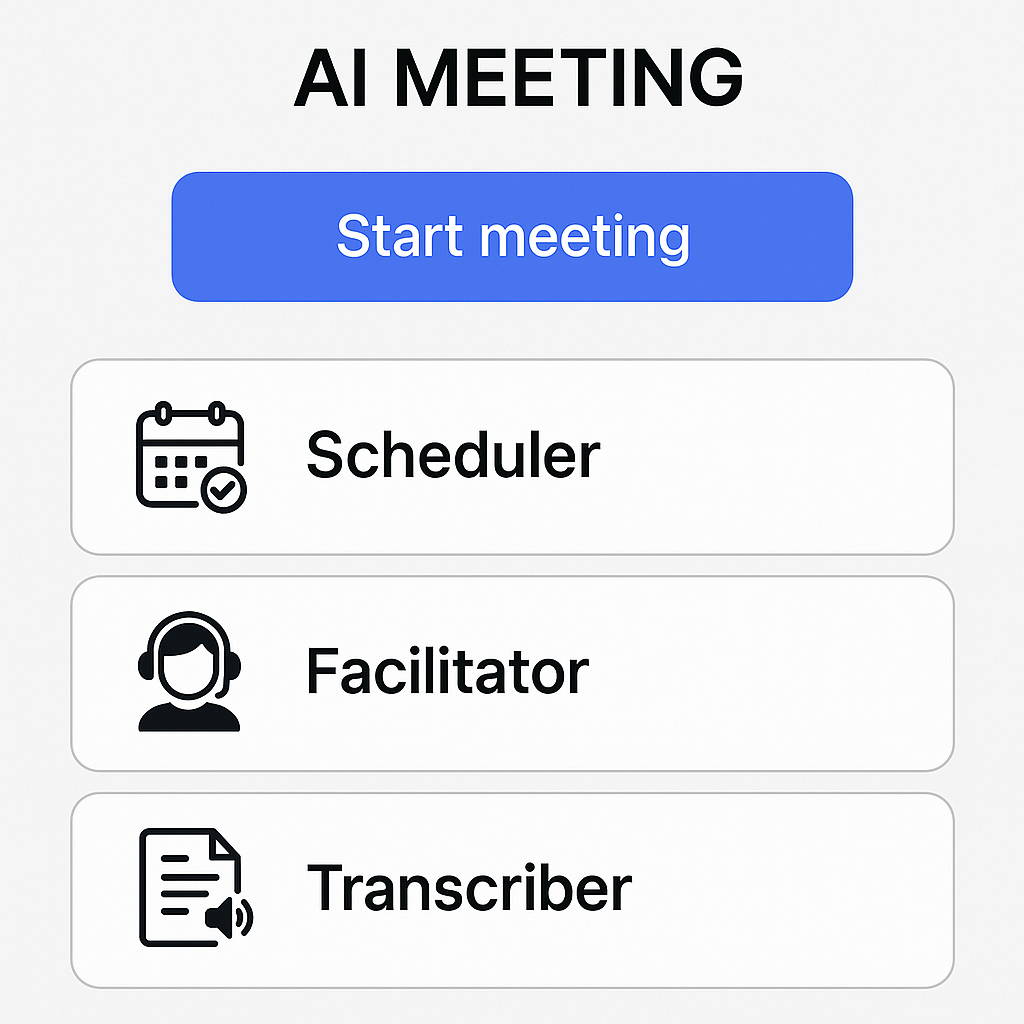

--- Displaying Final Design Image After Multiple Prompts---
--- This is the final image we chose---


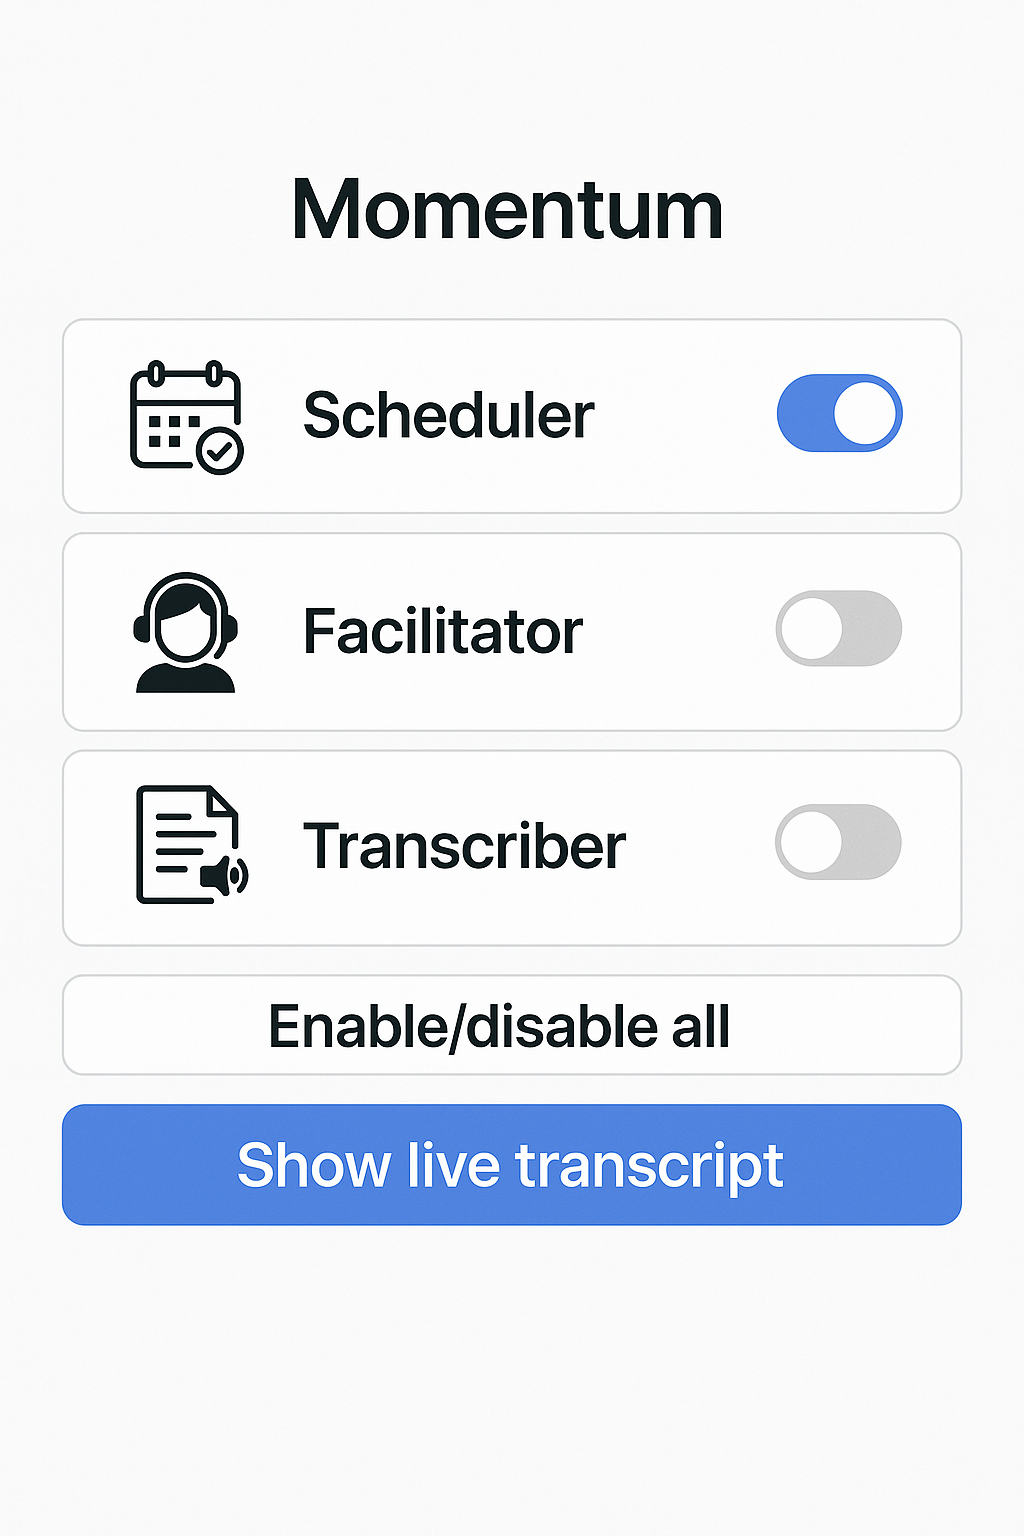

In [15]:
# This image was generated by prompting ChatGPT multiple times.
# The original prompt was:
# "We are developing an app to streamline meetings using ai agents.
# The agents are Scheduler, Facilitator, and Transcriber. 
# can you generate an image of what the UI could look like."
# We had multiple prompts to refine the design until we were satisfied with the result.

# Here is the original design image.
img_path = "original_design.png"
print("--- Displaying Original Design Image From First Prompt---")
if os.path.exists(img_path):
	display(Image(filename=img_path))
else:
	print(f"File not found: {img_path}")

#Here is the final design image. 
img_path = "momentum.png"
print("--- Displaying Final Design Image After Multiple Prompts---")
print("--- This is the final image we chose---")
if os.path.exists(img_path):
	display(Image(filename=img_path))
else:
	print(f"File not found: {img_path}")

In [ ]:
# Define the variable for path to image

login_form_url = "ai_capstone/artifacts/momentum.png"
display(Image(url=login_form_url))

In [ ]:
# Generate a single React component from the image.
generate_ui_prompt = f"""
You are a React developer. Your task is to generate a single React component based on the provided image.
The image is provided here:

{login_form_url}

Use Tailwind CSS for styling.
Analyze the image and generate a single React component. 
The output should be a single block of JSX code.
Make the design as close to the image as possible, including all elements such as buttons, input fields, and layout.
Ensure the component is functional and visually appealing.
The components should have buttons for enabling agent choices.
There should be transcripts visualized in the UI.
Do not include any additional comments or explanations in the output.
"""


print("--- Generating Monolithic UI Component ---")
if model_name:
    generated_monolithic_code = get_vision_completion(generate_ui_prompt, login_form_url, client, model_name, api_provider)
    cleaned_code = clean_llm_output(generated_monolithic_code, language='jsx')
    display(Code(cleaned_code, language='jsx'))
    save_artifact(cleaned_code, "ai_capstone/app/agent_monolithic.jsx")
else:
    print("Skipping UI generation because no valid model is configured.")
    cleaned_code = ""

In [ ]:
# Refactoring the monolithic code into smaller components.
refactor_ui_prompt = f"""
You are a senior React developer. Your task is to refactor the provided monolithic React component into smaller, reusable components.
The monolithic code is provided below:
{cleaned_code}
Refactor the code into smaller, reusable components including styled buttons and inputs with icons.
The final output should be the complete refactored code with all components defined and used within the main component.
Use SOLID design principles and ensure the components are modular and maintainable.
"""

print("--- Refactoring UI into Components ---")
if cleaned_code:
    refactored_code = get_completion(refactor_ui_prompt, client, model_name, api_provider)
    cleaned_refactored_code = clean_llm_output(refactored_code, language='jsx')
    display(Code(cleaned_refactored_code, language='jsx'))
    print(cleaned_refactored_code)
else:
    print("Skipping refactoring because monolithic code was not generated.")
    cleaned_refactored_code = ""

## 🚀 Frontend Integration

After generating the React code, we added it to:

- `ai_capstone/momentum_dashboard/src/components/dashboard.jsx`

To start the development server, run:

```bash
npm run dev
```

Then open your browser and visit:

- [http://localhost:5173](http://localhost:5173)

> 💡 **Tip:**  
> Make sure all dependencies are installed with `npm install` before running the dev server!

## 🤖 AI Agents Overview

Momentum leverages multiple specialized AI agents to enhance meeting productivity and collaboration:

- **Note-Taking Agent:** Automatically transcribes and summarizes meeting discussions, ensuring key points and action items are captured in real time.
- **Scheduler Agent:** Assists with scheduling, agenda management, and timekeeping to keep meetings on track and organized.
- **Topic Monitoring Agent:** Monitors the relevance of ongoing discussions to the set meeting topic, gently guiding participants back on track if conversations drift.

Each agent operates independently but communicates through a shared WebSocket chat interface, enabling seamless collaboration and real-time feedback. Agents are designed to run both interactively and headless (in containers), supporting robust deployment and integration with the Momentum platform.

> These agents work together to automate routine meeting tasks, provide intelligent insights, and help teams stay focused and efficient.

The agent code uses LangGraph and gemini-2.5-flash for the LLM. We tried generating it completely with AI by using the openapi spec, but it was not working. We manually coded a working skeleton of the agent behavior working in CLI. Then we used GitHub CoPilot to create a /chat websocket endpoint in the backend and websocket connectivity to the front end, and agents.

## Containerization
You can run the entire working stack with `docker compose up`

This application was containerized by running Day4 Lab2.
For all the python applications, we created requirements.txt files. Next we used the following prompt to generate the Dockerfiles with some manual intervention.

In [ ]:
# TODO: Write a prompt to generate a multi-stage Dockerfile.
dockerfile_prompt = """


Generate a multi-stage Dockerfile to run a Python application. The Dockerfile should:
1. Use a lightweight base image python:3.11-alpine for the final stage.
2. For the build stage install all necessary dependencies from the requirements.txt file.
3. Add dev and prod stages to the Dockerfile. The dev stage also installs requirements-dev.txt. 
4. Copy the application code into the container.
5. Set the working directory to the /app
6. Create a non-root user "appuser" to run the application.
7. Modify the file permissions to ensure the application can run correctly.
8. Expose the necessary port for the application.
"""

print("--- Generating Dockerfile ---")
dockerfile_content = get_completion(dockerfile_prompt, client, model_name, api_provider)
cleaned_dockerfile = clean_llm_output(dockerfile_content, language='dockerfile')
print(cleaned_dockerfile)

if cleaned_dockerfile:
    save_artifact(cleaned_dockerfile, "ai_capstone/agents/Dockerfile")

### 🎨 Frontend Containerization Approach

For the frontend, a different prompt was needed to generate a multi-stage Dockerfile tailored for NodeJS applications. This ensured the React dashboard was efficiently containerized, with optimized builds and secure deployment practices.



In [ ]:
# TODO: Write a prompt to generate a multi-stage Dockerfile.
dockerfile_prompt = """


Generate a multi-stage Dockerfile to run a NodeJS application. The Dockerfile should:
1. Use a lightweight base image.
2. Install the necessary dependencies from package.json and package-lock.json.
4. Copy the application code into the container.
5. Set the working directory to the /app
6. Create a non-root user "appuser" to run the application.
7. Modify the file permissions to ensure the application can run correctly.
8. Expose the necessary port for the application.
"""

print("--- Generating Dockerfile ---")
dockerfile_content = get_completion(dockerfile_prompt, client, model_name, api_provider)
cleaned_dockerfile = clean_llm_output(dockerfile_content, language='dockerfile')
print(cleaned_dockerfile)

if cleaned_dockerfile:
    save_artifact(cleaned_dockerfile, "ai_capstone/momentum_dashboard/Dockerfile")

A `docker-compose.yml` file was manually created, but sped up with the help of CoPilot in VS Code, which seemed to understand the directory struction and have context of the Dockerfiles.